In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,KFold
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss
from collections import defaultdict
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_rows',2000)

In [2]:
%%time
train = pd.read_csv("C:/Users/lohitr/Downloads/Hackathon/Banking/train_fNxu4vz.csv")
test = pd.read_csv("C:/Users/lohitr/Downloads/Hackathon/Banking/test_fjtUOL8.csv")

Wall time: 770 ms


In [3]:
train

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3


In [4]:
test

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109536,10273846,"15,000",9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,32.0,13,57,Male
109537,10273847,"9,600",10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,17.0,9,34,Male
109538,10273848,"2,000",5 years,Rent,37850.0,not verified,credit_card,11.60,0,NaN,10,11,Male
109539,10273849,"2,125",6 years,Rent,30000.0,not verified,other,24.88,0,NaN,5,6,Male


In [5]:
train.shape , test.shape

((164309, 14), (109541, 13))

In [6]:
train.describe()

,Loan_ID,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,1.643090e+05,1.392070e+05,164309.000000,164309.000000,75930.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,7.333116e+04,17.207189,0.781698,34.229356,11.193818,25.067665,2.158951
std,4.743207e+04,6.037750e+04,7.845083,1.034747,21.761180,4.991813,11.583067,0.738364
min,1.000000e+07,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.004108e+07,4.500000e+04,11.370000,0.000000,16.000000,8.000000,17.000000,2.000000
50%,1.008216e+07,6.300000e+04,16.840000,0.000000,31.000000,10.000000,23.000000,2.000000
75%,1.012323e+07,8.869750e+04,22.780000,1.000000,50.000000,14.000000,32.000000,3.000000
max,1.016431e+07,7.500000e+06,39.990000,8.000000,180.000000,76.000000,156.000000,3.000000


In [7]:
#train.dtypes
Interest_Rate= train.Interest_Rate
train.drop('Interest_Rate',axis=1,inplace=True)
Loan_ID=test.Loan_ID
#df = train.append(test)
df=train
df.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female


In [8]:
for data in (train, test):
    missing_stats = data.isnull().mean()
    print(100 * missing_stats[missing_stats != 0], 2)

Length_Employed             4.486060
Home_Owner                 15.427639
Annual_Income              15.277313
Months_Since_Deliquency    53.788289
dtype: float64 2
Length_Employed             4.506075
Home_Owner                 15.255475
Annual_Income              15.426187
Months_Since_Deliquency    53.732392
dtype: float64 2


In [9]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Loan_ID: 164309
Loan_Amount_Requested: 1290
Length_Employed: 11
Home_Owner: 5
Annual_Income: 12305
Income_Verified: 3
Purpose_Of_Loan: 14
Debt_To_Income: 3953
Inquiries_Last_6Mo: 9
Months_Since_Deliquency: 122
Number_Open_Accounts: 58
Total_Accounts: 100
Gender: 2


In [ ]:
#sns.pairplot(data=train,diag_kind='hist',hue='Interest_Rate',diag_kws = {'alpha':0.55, 'bins':5})

In [10]:
categories = df.select_dtypes(include=['object']).columns.tolist()[:]
print(categories)

['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']


In [11]:
for col in categories:
    print(f"{col}:\n{df[col].value_counts()}\n")

Loan_Amount_Requested:
10,000    11622
12,000     9018
15,000     8459
20,000     7993
35,000     5844
8,000      5174
5,000      4842
6,000      4790
16,000     4376
25,000     4001
18,000     3992
24,000     3526
30,000     2909
7,000      2628
14,000     2509
28,000     2460
9,000      2161
4,000      2112
21,000     2038
3,000      1923
13,000     1470
11,000     1353
7,200      1283
9,600      1262
17,000     1093
7,500      1055
22,000     1018
2,000       970
14,400      966
6,500       821
4,800       820
8,400       734
11,200      727
5,500       723
2,500       679
3,500       647
8,500       645
11,500      592
10,500      589
3,600       583
6,400       578
5,600       575
19,200      564
4,500       527
19,000      520
10,800      484
1,000       462
16,800      462
2,400       445
17,500      442
23,000      440
12,500      438
4,200       424
32,000      409
12,800      388
1,500       386
26,000      357
9,500       356
8,875       343
13,200      323
10,400      317
1


Length_Employed:
10+ years    52915
2 years      14620
3 years      12974
< 1 year     12805
5 years      10814
1 year       10422
4 years       9784
7 years       9308
6 years       9094
8 years       7917
9 years       6285
Name: Length_Employed, dtype: int64

Home_Owner:
Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

Income_Verified:
VERIFIED - income           59421
VERIFIED - income source    53015
not verified                51873
Name: Income_Verified, dtype: int64

Purpose_Of_Loan:
debt_consolidation    97101
credit_card           36684
home_improvement       9269
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                837
wedding                 828
house                   773
renewable_energy        123
educational             121
Name: Purpose_Of_Loan, dtype: int64



In [ ]:
sns.heatmap(df.corr(), vmin=0, vmax=1, cmap="Blues", linewidths=1.5, annot=True)

,Total,Percent
Gender,0,0.0
Total_Accounts,0,0.0
Number_Open_Accounts,0,0.0
Months_Since_Deliquency,0,0.0
Inquiries_Last_6Mo,0,0.0


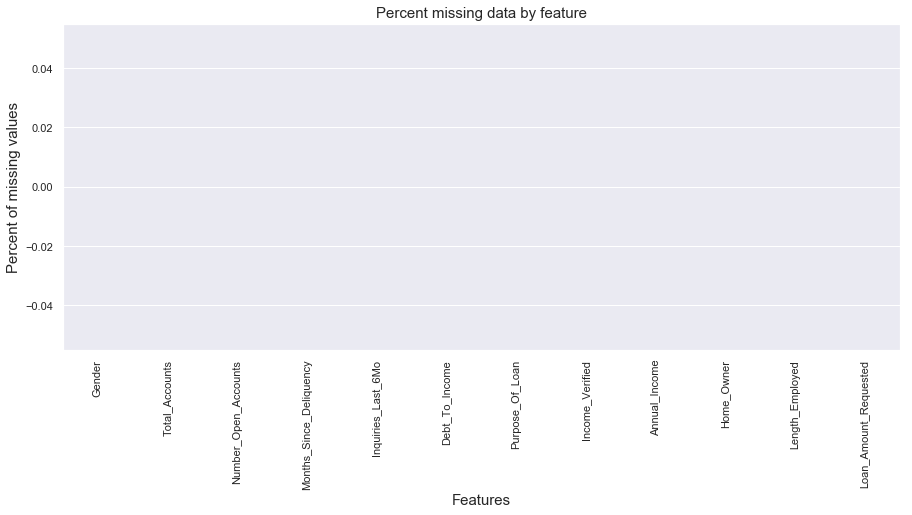

In [15]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [13]:
df.drop('Loan_ID',inplace=True,axis=1)

In [14]:
df.Months_Since_Deliquency.unique()

df.Months_Since_Deliquency.value_counts()

df.Months_Since_Deliquency.fillna(df.Months_Since_Deliquency.median(),inplace=True)

df.Length_Employed.value_counts()

mean_value=df['Annual_Income'].mean()
df['Annual_Income']=df['Annual_Income'].fillna(mean_value)

df['Home_Owner'] = df['Home_Owner'].fillna( df['Home_Owner'].dropna().mode().values[0] )

df['Length_Employed']=df['Length_Employed'].fillna(df['Length_Employed'].dropna().mode().values[0])


In [ ]:
df.Months_Since_Deliquency.value_counts()

In [ ]:
df.Months_Since_Deliquency.fillna(df.Months_Since_Deliquency.median(),inplace=True)

In [ ]:
df.Length_Employed.value_counts()

In [ ]:
# from sklearn.impute import SimpleImputer 
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# #imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# imputer.fit(df.Length_Employed)
# #train= imp.transform(train)


# # Get dummies
# Cat_Dummies = pd.get_dummies(df.Home_Owner,  drop_first=True)
# # X head
# Cat_Dummies.head()
# def replace_home(Home_Owner):
#     """
#     This function codes the Home_Owner attained.
#     """
#     if Home_Owner == 'None':
#         return 5
#     elif Home_Owner == 'Other':
#         return 4
#     elif Home_Owner =='Own':
#         return 3
#     elif Home_Owner == 'Rent':
#         return 2
#     elif Home_Owner == 'Mortgage':
#         return 1



# df['Home_Owner'] = df['Home_Owner'].apply(lambda x: replace_home(x))


# df.Length_Employed.fillna(df.Length_Employed.median(),inplace=True)
# df.Home_Owner.fillna(df.Home_Owner.mean(),inplace=True)
# df.Length_Employed.value_counts().mean()
# df.Annual_Income.value_counts()
# df.Annual_Income.fillna(df.Annual_Income.mode(),inplace=True)
#len_empl= df['Length_Employed'].median()
#df['Length_Employed']=df['Length_Employed'].fillna(len_empl)

#home_owner=df['Home_Owner'].mean()
#df['Home_Owner']=df['Home_Owner'].fillna(home_owner)
#df.Length_Employed.fillna(df.Length_Employed.median(),inplace=True)
#df..fillna(df.Home_Owner.mean(),inplace=True)

In [16]:
mean_value=df['Annual_Income'].mean()
df['Annual_Income']=df['Annual_Income'].fillna(mean_value)



In [17]:
df.Home_Owner.value_counts()

Mortgage    95694
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [18]:
df['Home_Owner'] = df['Home_Owner'].fillna( df['Home_Owner'].dropna().mode().values[0] )


In [19]:
df['Length_Employed']=df['Length_Employed'].fillna(df['Length_Employed'].dropna().mode().values[0])

In [20]:
df.isnull().sum()

Loan_Amount_Requested      0
Length_Employed            0
Home_Owner                 0
Annual_Income              0
Income_Verified            0
Purpose_Of_Loan            0
Debt_To_Income             0
Inquiries_Last_6Mo         0
Months_Since_Deliquency    0
Number_Open_Accounts       0
Total_Accounts             0
Gender                     0
dtype: int64

In [21]:
df.dtypes

Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
dtype: object

In [ ]:
df

In [ ]:
#df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int)
#df['Loan_Amount_Requested']=pd.to_numeric(df['Loan_Amount_Requested'], errors='coerce')
#df['Length_Employed']=pd.to_numeric(df['Length_Employed'], errors='coerce')
#df['Home_Owner']=df['Home_Owner'].map({'Mortage':0,'Rent':1,'Own':2,'Other':3,'None':4})

In [ ]:
df.head()

In [ ]:
categories

In [ ]:
df['Length_Employed'] = df['Length_Employed'].str.rstrip('<')

In [22]:
df['Home_Owner']=df['Home_Owner'].astype('category')
df['Home_Owner'] = df['Home_Owner'].cat.codes

df['Income_Verified']=df['Income_Verified'].astype('category')
df['Income_Verified']=df['Income_Verified'].cat.codes

df['Purpose_Of_Loan']=df['Purpose_Of_Loan'].astype('category')
df['Purpose_Of_Loan']=df['Purpose_Of_Loan'].cat.codes

df['Gender']=df['Gender'].astype('category')
df['Gender']=df['Gender'].cat.codes

df['Length_Employed']=df['Length_Employed'].astype('category')
df['Length_Employed']=df['Length_Employed'].cat.codes

df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(',','').astype(int)

In [ ]:

#df['Loan_Amount_Requested'].astype('int64')

In [ ]:
#list of categorical variables
cat_cols = [2,3,5,6,12]
df_cat=df[df.columns[cat_cols]]
df_cat

In [ ]:
df

In [ ]:
df.dtypes

In [23]:
import xgboost as xgb
#from sklearn import cross_validation, metrics
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [24]:
X=df.iloc[:, 1:]
X

,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10,4,68000.000000,2,0,18.37,0,31.0,9,14,0
1,4,0,73331.159434,0,2,14.93,0,17.0,12,24,0
2,7,0,75566.400000,1,2,15.88,0,31.0,12,16,1
3,10,0,56160.000000,1,2,14.34,3,31.0,16,22,1
4,8,3,96000.000000,1,2,22.17,1,31.0,19,30,0
...,...,...,...,...,...,...,...,...,...,...,...
164304,1,4,73331.159434,1,1,13.56,0,31.0,13,16,1
164305,8,3,73331.159434,1,11,9.12,0,36.0,13,30,1
164306,1,0,73331.159434,0,1,18.17,1,31.0,17,30,1
164307,4,4,73331.159434,2,6,18.75,1,48.0,16,62,0


In [25]:
Interest_Rate

0         1
1         3
2         3
3         3
4         1
         ..
164304    2
164305    2
164306    1
164307    3
164308    2
Name: Interest_Rate, Length: 164309, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Interest_Rate, test_size=0.30, random_state=23)

# XGBoost

In [60]:
# I used this packages for Hyperparametr tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=100,random_state=0)
#help(xgb)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
xgb_y_pred = xgb.predict(X_test)

In [62]:
print(confusion_matrix(y_test,xgb_y_pred))

[[ 2487  6134  1478]
 [ 1836 13009  6273]
 [  490  7939  9647]]


In [63]:
print(classification_report(y_test,xgb_y_pred))

              precision    recall  f1-score   support

           1       0.52      0.25      0.33     10099
           2       0.48      0.62      0.54     21118
           3       0.55      0.53      0.54     18076

    accuracy                           0.51     49293
   macro avg       0.52      0.47      0.47     49293
weighted avg       0.51      0.51      0.50     49293



In [64]:

print(accuracy_score(y_test, xgb_y_pred))

0.5100724240764408


# LGB Classifier

In [50]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=500,random_state=0)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
lgbm_y_pred = lgbm.predict(X_test)


In [52]:
print(confusion_matrix(y_test,lgbm_y_pred))

[[ 2552  6009  1538]
 [ 1959 12851  6308]
 [  551  7907  9618]]


In [53]:
print(classification_report(y_test,lgbm_y_pred))

              precision    recall  f1-score   support

           1       0.50      0.25      0.34     10099
           2       0.48      0.61      0.54     21118
           3       0.55      0.53      0.54     18076

    accuracy                           0.51     49293
   macro avg       0.51      0.46      0.47     49293
weighted avg       0.51      0.51      0.50     49293



In [54]:
print(accuracy_score(y_test, lgbm_y_pred))

0.5075974276266407


In [56]:

from sklearn.neighbors import KNeighborsClassifier 
  
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [58]:
knn_y_pred = knn.predict(X_test)

In [59]:
print(accuracy_score(y_test, knn_y_pred))

0.41147830320735196


# GaussianNB 

In [65]:
# training the model on training set 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [66]:
gnb_y_pred = gnb.predict(X_test)

In [67]:
print(confusion_matrix(y_test,gnb_y_pred))

[[  352  7758  1989]
 [  272 14870  5976]
 [  143 10094  7839]]


In [68]:
print(classification_report(y_test,gnb_y_pred))

              precision    recall  f1-score   support

           1       0.46      0.03      0.06     10099
           2       0.45      0.70      0.55     21118
           3       0.50      0.43      0.46     18076

    accuracy                           0.47     49293
   macro avg       0.47      0.39      0.36     49293
weighted avg       0.47      0.47      0.42     49293



In [69]:
print(accuracy_score(y_test, gnb_y_pred))

0.46783518958067066


# RandomForest Classifier 

In [70]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [71]:
y_pred = classifier.predict(X_test)



In [72]:
print(confusion_matrix(y_test,y_pred))

[[ 2473  5756  1870]
 [ 2130 12183  6805]
 [  700  7764  9612]]


In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.47      0.24      0.32     10099
           2       0.47      0.58      0.52     21118
           3       0.53      0.53      0.53     18076

    accuracy                           0.49     49293
   macro avg       0.49      0.45      0.46     49293
weighted avg       0.49      0.49      0.48     49293



In [74]:
print(accuracy_score(y_test, y_pred))

0.4923214249487757


In [77]:
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('xg',xgb),('lg',lgb)],voting='soft')
vclf

VotingClassifier(estimators=[('xg',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=1000,
                                            n_jobs=1, nthread=None,
                                            objective='multi:softprob',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1)),
                  

# test Data

In [ ]:
test

In [ ]:
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [ ]:
test.Months_Since_Deliquency.unique()


In [ ]:
test.Months_Since_Deliquency.value_counts()
test.Months_Since_Deliquency.fillna(test.Months_Since_Deliquency.median(),inplace=True)

In [ ]:
test.Length_Employed.value_counts()
test['Length_Employed']=test['Length_Employed'].fillna(test['Length_Employed'].dropna().mode().values[0])

In [ ]:
test['Home_Owner'] = test['Home_Owner'].fillna( test['Home_Owner'].dropna().mode().values[0] )

In [ ]:
mean_value=test['Annual_Income'].mean()
test['Annual_Income']=test['Annual_Income'].fillna(mean_value)

In [ ]:
test.dtypes

In [ ]:
test['Home_Owner']=test['Home_Owner'].astype('category')
test['Home_Owner'] = test['Home_Owner'].cat.codes

test['Income_Verified']=test['Income_Verified'].astype('category')
test['Income_Verified']=test['Income_Verified'].cat.codes

test['Purpose_Of_Loan']=test['Purpose_Of_Loan'].astype('category')
test['Purpose_Of_Loan']=test['Purpose_Of_Loan'].cat.codes

test['Gender']=test['Gender'].astype('category')
test['Gender']=test['Gender'].cat.codes

test['Length_Employed']=test['Length_Employed'].astype('category')
test['Length_Employed']=test['Length_Employed'].cat.codes

test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].str.replace(',','').astype(int)

In [ ]:
test.dtypes

In [ ]:
# Predicting on given test Dataset
#

test.drop('Loan_ID',axis=1,inplace=True)

In [ ]:
predictions=xgb.predict(test)

In [ ]:
result=pd.DataFrame(predictions,columns=["Interest_Rate"])
result

In [ ]:
np.unique(result.Interest_Rate,return_counts=True)

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
seed = 8
skf=StratifiedKFold(n_splits=5, random_state=None)
from sklearn.model_selection import cross_val_score
seed = 8
kfold = model_selection.KFold(n_splits=8, random_state=seed)
score=cross_val_score(gnb,X_train,y_train,cv=skf)
score

In [ ]:
sub=pd.read_csv("C:/Users/lohitr/Downloads/Hackathon/Banking/test_fjtUOL8.csv")

In [ ]:
#df = pd.concat( [sub, result], axis=1)
#submission = pd.DataFrame({"Loan_ID":sub["Loan_ID"],"Interest_Rate": xgb_y_pred})
#submission.to_csv('C:/Users/lohitr/Desktop/sample_submission.csv', index=False)
#sub.Loan_ID  , result.Interest_Rate
submission = pd.DataFrame({"Loan_ID":sub["Loan_ID"],"Interest_Rate": result["Interest_Rate"]})
submission.to_csv('C:/Users/lohitr/Desktop/sample_submission.csv', index=False)